In [79]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from wwo_hist import retrieve_hist_data
import os
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
import datetime
from sklearn import preprocessing
from scipy import stats

bikeday = pd.read_csv('day.csv')
bikehour = pd.read_csv('hour.csv')

In [80]:
hdf = bikehour.rename(columns={'dteday': 'date', 'yr': 'year', 'mnth': 'month', 'hr': 'hour', 'workingday': 'is_workday', 'hum': 'humidity', 'cnt': 'users_total', 'holiday': 'is_holiday', 'atemp': 'felt_temperature', 'temp': 'temperature', 'weathersit': 'weather', 'casual': 'casual_users', 'registered': 'registered_users'})

In [81]:
hdf['season'] = hdf['season'].replace([1, 2, 3, 4], ['winter', 'spring', 'summer', 'fall'])
hdf['year'] = hdf['year'].replace([0, 1], [2011, 2012])
hdf['weekday'] = hdf['weekday'].replace([0, 1, 2, 3, 4, 5, 6], ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
hdf['month'] = hdf['month'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
hdf['weather'] = hdf['weather'].replace([1, 2, 3, 4], ['A', 'B', 'C', 'D'])
hdf['is_holiday'] = hdf['is_holiday'].replace([1, 0], [True, False])
hdf['is_workday'] = hdf['is_workday'].replace([1, 0], [True, False])
hdf['is_weekend'] = np.where((hdf['weekday'] == 'Saturday') | (hdf['weekday'] == 'Sunday'), True, False)

In [ ]:
#Download weather data using wwo_hist (just for reference):
# frequency=1
#start_date = '01-JAN-2011'
#end_date = '31-DEC-2012'
#api_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
#location_list = ['washington']

#hist_weather_data = retrieve_hist_data(api_key,
#                                location_list,
#                                start_date,
#                                end_date,
#                                frequency,
#                                location_label = False,
#                                export_csv = True,
#                                store_df = True) 

In [82]:
washdf = pd.read_csv("C:\\Users\HP\\Documents\\GIT\\NEW\\antelope\\bikeshare\\2005-20\\2015-20\\washington.csv")
washdf['date_time'] = washdf['date_time'].astype('datetime64')
wash_sel_df = washdf[['date_time', 'totalSnow_cm', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'visibility']]

In [83]:
scaler = MinMaxScaler() 

column_names_to_normalize = ['totalSnow_cm', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'visibility']
x = wash_sel_df[column_names_to_normalize].values
x_scaled = scaler.fit_transform(x)
wash_norm = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = wash_sel_df.index)
wash_sel_df[column_names_to_normalize] = wash_norm

In [84]:
hdf['date'] = hdf['date'].astype('datetime64')
hdf['date_time'] = pd.to_datetime(hdf.date) + pd.to_timedelta(hdf.hour, unit='h')

In [85]:
hdf = hdf.drop(columns=['humidity'])

In [87]:
capital_df = pd.merge(hdf, wash_sel_df, on='date_time')

In [88]:
capital_df = capital_df.drop(columns=['date_time'])

In [89]:
capital_df.dtypes

instant                      int64
date                datetime64[ns]
season                      object
year                         int64
month                       object
hour                         int64
is_holiday                    bool
weekday                     object
is_workday                    bool
weather                     object
temperature                float64
felt_temperature           float64
windspeed                  float64
casual_users                 int64
registered_users             int64
users_total                  int64
is_weekend                    bool
totalSnow_cm               float64
WindGustKmph               float64
cloudcover                 float64
humidity                   float64
precipMM                   float64
visibility                 float64
dtype: object

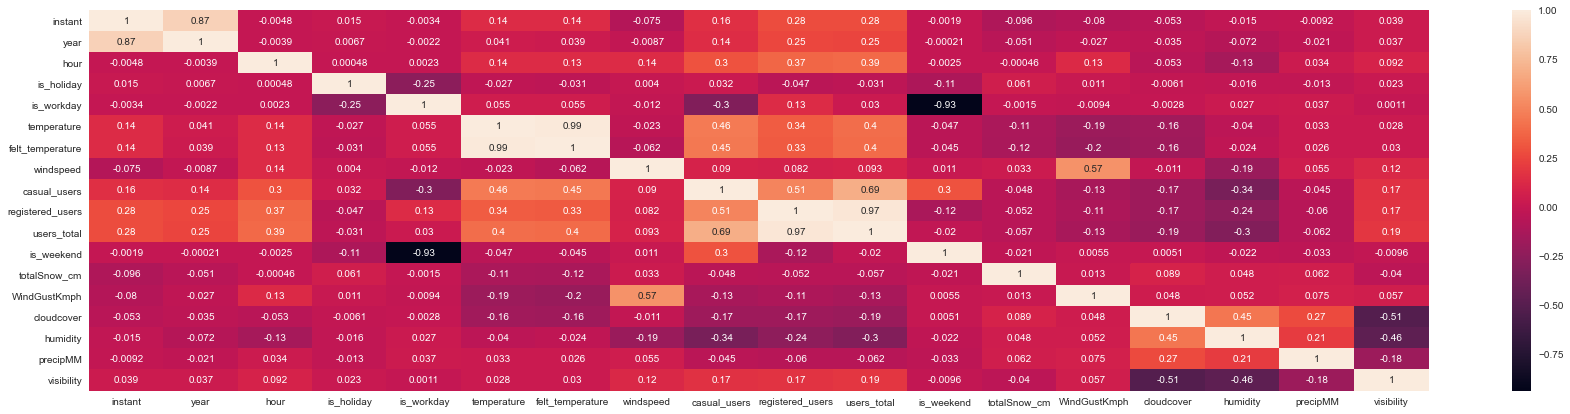

In [38]:
corr_mat = capital_df.corr()
plt.figure(figsize=(30,7))
sns.heatmap(corr_mat, annot = True)
#plt.savefig("correlation.png")
plt.show()

<AxesSubplot:>

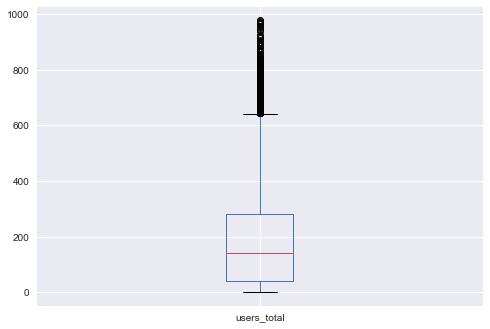

In [90]:
capital_df.users_total.plot.box()

In [50]:
capital_df.loc[capital_df['users_total'] > 700]

,instant,date,season,year,month,hour,is_holiday,weekday,is_workday,weather,...,casual_users,registered_users,users_total,is_weekend,totalSnow_cm,WindGustKmph,cloudcover,humidity,precipMM,visibility
10359,10360,2012-03-12,winter,2012,March,18,False,Monday,True,B,...,89,623,712,False,0.0,0.189189,0.49,0.842857,0.0,1.0
10383,10384,2012-03-13,winter,2012,March,18,False,Tuesday,True,A,...,96,638,734,False,0.0,0.148649,0.04,0.785714,0.0,1.0
10406,10407,2012-03-14,winter,2012,March,17,False,Wednesday,True,A,...,140,642,782,False,0.0,0.216216,0.04,0.285714,0.0,1.0
10407,10408,2012-03-14,winter,2012,March,18,False,Wednesday,True,A,...,102,647,749,False,0.0,0.270270,0.04,0.385714,0.0,1.0
10430,10431,2012-03-15,winter,2012,March,17,False,Thursday,True,A,...,79,634,713,False,0.0,0.229730,0.06,0.671429,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16717,16718,2012-12-04,fall,2012,December,8,False,Tuesday,True,B,...,21,700,721,False,0.0,0.148649,0.40,0.857143,0.0,1.0
16726,16727,2012-12-04,fall,2012,December,17,False,Tuesday,True,A,...,43,700,743,False,0.0,0.297297,0.36,0.771429,0.0,1.0
16727,16728,2012-12-04,fall,2012,December,18,False,Tuesday,True,A,...,38,693,731,False,0.0,0.270270,0.30,0.800000,0.0,1.0
16741,16742,2012-12-05,fall,2012,December,8,False,Wednesday,True,B,...,22,737,759,False,0.0,0.364865,0.16,0.457143,0.0,1.0


<AxesSubplot:>

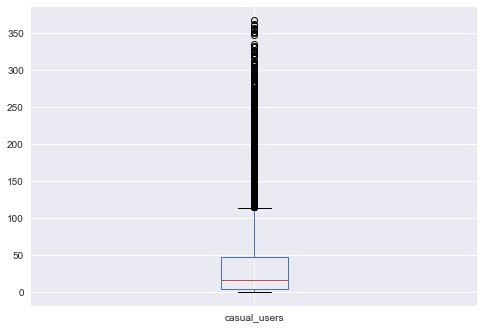

In [51]:
capital_df.casual_users.plot.box()

In [53]:
capital_df.loc[capital_df['casual_users'] > 250]

,instant,date,season,year,month,hour,is_holiday,weekday,is_workday,weather,...,casual_users,registered_users,users_total,is_weekend,totalSnow_cm,WindGustKmph,cloudcover,humidity,precipMM,visibility
6623,6624,2011-10-08,fall,2011,October,13,False,Saturday,False,A,...,256,229,485,True,0.0,0.094595,0.00,0.371429,0.000000,1.0
6624,6625,2011-10-08,fall,2011,October,14,False,Saturday,False,A,...,251,214,465,True,0.0,0.108108,0.00,0.400000,0.000000,1.0
6625,6626,2011-10-08,fall,2011,October,15,False,Saturday,False,A,...,262,234,496,True,0.0,0.108108,0.00,0.442857,0.000000,1.0
6648,6649,2011-10-09,fall,2011,October,14,False,Sunday,False,A,...,272,228,500,True,0.0,0.027027,0.01,0.400000,0.000000,1.0
10473,10474,2012-03-17,winter,2012,March,12,False,Saturday,False,A,...,286,365,651,True,0.0,0.108108,0.30,0.571429,0.003788,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16148,16149,2012-11-10,fall,2012,November,14,False,Saturday,False,A,...,280,347,627,True,0.0,0.175676,0.08,0.585714,0.000000,1.0
16171,16172,2012-11-11,fall,2012,November,13,False,Sunday,False,A,...,262,424,686,True,0.0,0.162162,0.04,0.485714,0.000000,1.0
16172,16173,2012-11-11,fall,2012,November,14,False,Sunday,False,A,...,292,362,654,True,0.0,0.243243,0.04,0.557143,0.000000,1.0
16173,16174,2012-11-11,fall,2012,November,15,False,Sunday,False,A,...,304,420,724,True,0.0,0.324324,0.04,0.628571,0.000000,1.0


<AxesSubplot:>

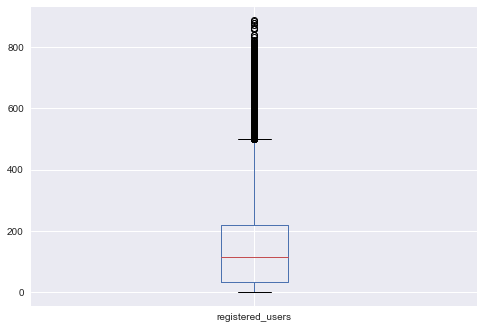

In [52]:
capital_df.registered_users.plot.box()

In [54]:
capital_df.loc[capital_df['registered_users'] > 650]

,instant,date,season,year,month,hour,is_holiday,weekday,is_workday,weather,...,casual_users,registered_users,users_total,is_weekend,totalSnow_cm,WindGustKmph,cloudcover,humidity,precipMM,visibility
10527,10528,2012-03-19,winter,2012,March,18,False,Monday,True,A,...,120,681,801,False,0.0,0.243243,0.21,0.914286,0.090909,0.7
10551,10552,2012-03-20,winter,2012,March,18,False,Tuesday,True,A,...,136,665,801,False,0.0,0.135135,0.80,0.871429,0.003788,1.0
10598,10599,2012-03-22,spring,2012,March,17,False,Thursday,True,A,...,154,656,810,False,0.0,0.108108,0.08,0.828571,0.034091,0.8
10599,10600,2012-03-22,spring,2012,March,18,False,Thursday,True,A,...,147,654,801,False,0.0,0.094595,0.07,0.914286,0.045455,0.7
10622,10623,2012-03-23,spring,2012,March,17,False,Friday,True,B,...,264,693,957,False,0.0,0.189189,0.11,0.642857,0.003788,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16885,16886,2012-12-11,fall,2012,December,8,False,Tuesday,True,B,...,16,708,724,False,0.0,0.297297,0.15,0.542857,0.000000,1.0
16909,16910,2012-12-12,fall,2012,December,8,False,Wednesday,True,B,...,18,670,688,False,0.0,0.175676,0.19,0.542857,0.000000,1.0
16933,16934,2012-12-13,fall,2012,December,8,False,Thursday,True,A,...,24,655,679,False,0.0,0.229730,0.01,0.442857,0.000000,1.0
17053,17054,2012-12-18,fall,2012,December,8,False,Tuesday,True,A,...,10,652,662,False,0.0,0.270270,0.16,0.728571,0.000000,1.0


In [104]:
ddf = bikeday.rename(columns={'dteday': 'date', 'yr': 'year', 'mnth': 'month', 'hr': 'hour', 'workingday': 'is_workday', 'hum': 'humidity', 'cnt': 'users_total', 'holiday': 'is_holiday', 'atemp': 'felt_temperature', 'temp': 'temperature', 'weathersit': 'weather', 'casual': 'casual_users', 'registered': 'registered_users'})
ddf['season'] = ddf['season'].replace([1, 2, 3, 4], ['winter', 'spring', 'summer', 'fall'])
ddf['year'] = ddf['year'].replace([0, 1], [2011, 2012])
ddf['weekday'] = ddf['weekday'].replace([0, 1, 2, 3, 4, 5, 6], ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
ddf['month'] = ddf['month'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
ddf['weather'] = hdf['weather'].replace([1, 2, 3, 4], ['A', 'B', 'C', 'D'])
ddf['is_holiday'] = hdf['is_holiday'].replace([1, 0], [True, False])
ddf['is_workday'] = hdf['is_workday'].replace([1, 0], [True, False])
ddf['date'] = ddf['date'].astype('datetime64')
ddf['is_weekend'] = np.where((ddf['weekday'] == 'Saturday') | (ddf['weekday'] == 'Sunday'), True, False)


In [105]:
ddf = ddf.rename(columns={'date': 'date_time'})

In [106]:
ddf = ddf.drop(columns=['humidity'])

In [61]:
##os.mkdir('daily')
##os.chdir('daily')

#frequency=24
#start_date = '01-JAN-2011'
#end_date = '31-DEC-2012'
#api_key = 'xxxxxxxxxxxxxxxxxxxxxxxxx'
#location_list = ['washington']

#hist_weather_data = retrieve_hist_data(api_key,
#                                location_list,
#                                start_date,
#                                end_date,
#                                frequency,
#                                location_label = False,
#                                export_csv = True,
#                                store_df = True)



Retrieving weather data for washington


Currently retrieving data for washington: from 2011-01-01 to 2011-01-31
Time elapsed (hh:mm:ss.ms) 0:00:01.767155
Currently retrieving data for washington: from 2011-02-01 to 2011-02-28
Time elapsed (hh:mm:ss.ms) 0:00:03.495881
Currently retrieving data for washington: from 2011-03-01 to 2011-03-31
Time elapsed (hh:mm:ss.ms) 0:00:05.465034
Currently retrieving data for washington: from 2011-04-01 to 2011-04-30
Time elapsed (hh:mm:ss.ms) 0:00:08.069288
Currently retrieving data for washington: from 2011-05-01 to 2011-05-31
Time elapsed (hh:mm:ss.ms) 0:00:09.802981
Currently retrieving data for washington: from 2011-06-01 to 2011-06-30
Time elapsed (hh:mm:ss.ms) 0:00:12.650106
Currently retrieving data for washington: from 2011-07-01 to 2011-07-31
Time elapsed (hh:mm:ss.ms) 0:00:15.190601
Currently retrieving data for washington: from 2011-08-01 to 2011-08-31
Time elapsed (hh:mm:ss.ms) 0:00:17.306533
Currently retrieving data for washington: fro

In [107]:
washdf_d = pd.read_csv("C:\\Users\\HP\\Documents\\GIT\\NEW\\antelope\\bikeshare\\2005-20\\2015-20\\daily\\washington.csv")
washdf_d['date_time'] = washdf_d['date_time'].astype('datetime64')
wash_sel_d_df = washdf_d[['date_time', 'totalSnow_cm', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'visibility']]

In [108]:
scaler = MinMaxScaler() 

column_names_to_normalize = ['totalSnow_cm', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'visibility']
x = wash_sel_d_df[column_names_to_normalize].values
x_scaled = scaler.fit_transform(x)
wash_norm_d = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = wash_sel_d_df.index)
wash_sel_d_df[column_names_to_normalize] = wash_norm_d

In [109]:
capital_d_df = pd.merge(ddf, wash_sel_d_df, on='date_time')

In [110]:
capital_d_df

,instant,date_time,season,year,month,is_holiday,weekday,is_workday,weather,temperature,felt_temperature,windspeed,casual_users,registered_users,users_total,is_weekend,totalSnow_cm,WindGustKmph,cloudcover,humidity,precipMM,visibility
0,1,2011-01-01,winter,2011,January,False,Saturday,False,A,0.344167,0.363625,0.160446,331,654,985,True,0.0,0.409091,0.90,0.983051,0.013921,0.555556
1,2,2011-01-02,winter,2011,January,False,Sunday,False,A,0.363478,0.353739,0.248539,131,670,801,True,0.0,0.409091,0.74,0.881356,0.051624,0.666667
2,3,2011-01-03,winter,2011,January,False,Monday,False,A,0.196364,0.189405,0.248309,120,1229,1349,False,0.0,0.250000,0.03,0.254237,0.000000,1.000000
3,4,2011-01-04,winter,2011,January,False,Tuesday,False,A,0.200000,0.212122,0.160296,108,1454,1562,False,0.0,0.295455,0.10,0.406780,0.000000,1.000000
4,5,2011-01-05,winter,2011,January,False,Wednesday,False,A,0.226957,0.229270,0.186900,82,1518,1600,False,0.0,0.204545,0.16,0.474576,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,winter,2012,December,False,Thursday,True,A,0.254167,0.226642,0.350133,247,1867,2114,False,0.0,0.704545,0.28,0.677966,0.004060,1.000000
727,728,2012-12-28,winter,2012,December,False,Friday,True,A,0.253333,0.255046,0.155471,644,2451,3095,False,0.0,0.181818,0.25,0.644068,0.000000,1.000000
728,729,2012-12-29,winter,2012,December,False,Saturday,True,A,0.253333,0.242400,0.124383,159,1182,1341,True,0.0,0.295455,0.68,0.813559,0.015661,0.777778
729,730,2012-12-30,winter,2012,December,False,Sunday,True,A,0.255833,0.231700,0.350754,364,1432,1796,True,0.0,0.613636,0.10,0.593220,0.000000,1.000000


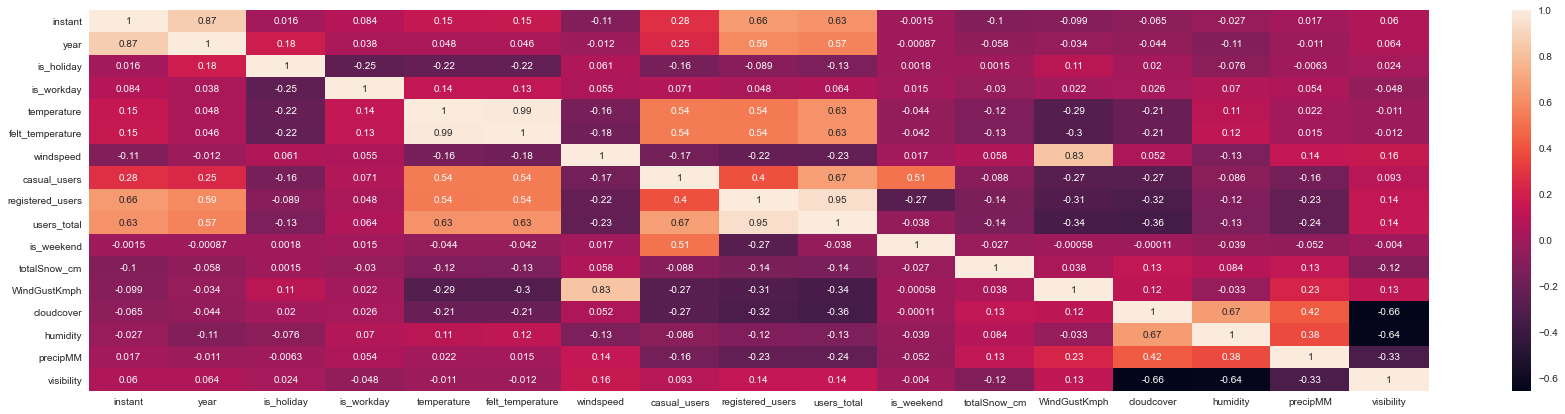

In [111]:
corr_mat_d = capital_d_df.corr()
plt.figure(figsize=(30,7))
sns.heatmap(corr_mat_d, annot = True)
#plt.savefig("correlation.png")
plt.show()

<AxesSubplot:>

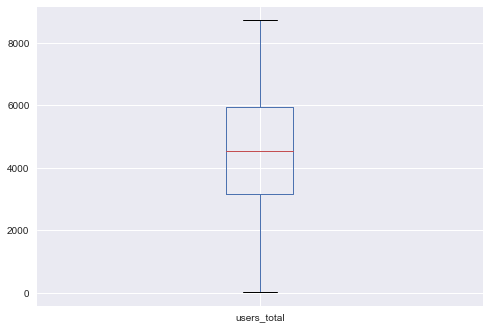

In [113]:
capital_d_df.users_total.plot.box()

<AxesSubplot:>

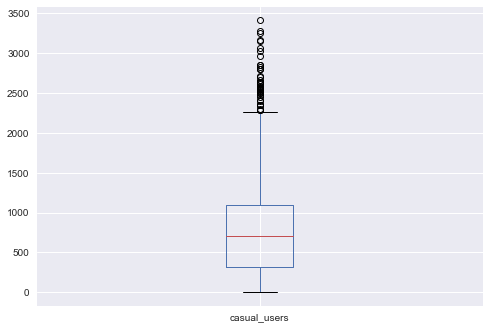

In [114]:
capital_d_df.casual_users.plot.box()

In [116]:
capital_d_df['casual_users'].sum()

620017

In [117]:
capital_d_df['registered_users'].sum()

2672662

In [119]:
capital_d_df.loc[capital_d_df['casual_users'] > 2300]

,instant,date_time,season,year,month,is_holiday,weekday,is_workday,weather,temperature,felt_temperature,windspeed,casual_users,registered_users,users_total,is_weekend,totalSnow_cm,WindGustKmph,cloudcover,humidity,precipMM,visibility
148,149,2011-05-29,sprin4g,2011,May,False,Sunday,True,B,0.667500,0.615550,0.213938,2355,2433,4788,True,0.0,0.159091,0.44,0.762712,0.000580,0.666667
184,185,2011-07-04,summer,2011,July,False,Monday,False,A,0.726667,0.665417,0.081479,3065,2978,6043,False,0.0,0.136364,0.25,0.610169,0.002900,0.888889
196,197,2011-07-16,summer,2011,July,False,Saturday,False,A,0.686667,0.638263,0.208342,2418,3505,5923,True,0.0,0.204545,0.05,0.559322,0.000000,0.888889
246,247,2011-09-04,summer,2011,September,False,Sunday,True,B,0.709167,0.665429,0.206467,2521,2419,4940,True,0.0,0.272727,0.29,0.745763,0.001740,0.777778
281,282,2011-10-09,fall,2011,October,False,Sunday,True,A,0.540833,0.523983,0.063450,2397,3114,5511,True,0.0,0.000000,0.01,0.576271,0.000000,1.000000
441,442,2012-03-17,winter,2012,March,False,Saturday,True,A,0.514167,0.505046,0.110704,3155,4681,7836,True,0.0,0.159091,0.29,0.796610,0.008121,0.888889
447,448,2012-03-23,sprin4g,2012,March,False,Friday,True,B,0.601667,0.570067,0.116300,2469,5893,8362,False,0.0,0.159091,0.10,0.711864,0.010441,0.666667
455,456,2012-03-31,sprin4g,2012,March,False,Saturday,True,B,0.424167,0.421708,0.250617,2301,3934,6235,True,0.0,0.250000,0.69,0.779661,0.011601,0.888889
456,457,2012-04-01,sprin4g,2012,April,False,Sunday,True,B,0.425833,0.417287,0.172267,2347,3694,6041,True,0.0,0.136364,0.45,0.711864,0.017401,0.888889
462,463,2012-04-07,sprin4g,2012,April,False,Saturday,True,A,0.437500,0.426129,0.274871,3252,3605,6857,True,0.0,0.363636,0.00,0.186441,0.000000,1.000000


<AxesSubplot:>

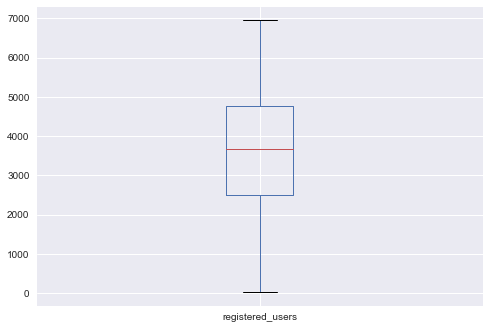

In [115]:
capital_d_df.registered_users.plot.box()